In [2]:
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.insert(0, '../src/')
import zivkovic as z
import coalescentmoments as c
import helpers as h

In [4]:
def fold(n, X):
    i_max = n//2
    k = np.arange(1, n-1)
    multiplicity = 1 + (k == n - k).astype(float)[:i_max]
    if X.ndim == 1:
        folded = (X + X[::-1])[:i_max]
        divisor = multiplicity
    elif X.ndim == 2:
        folded = (X + X[:,::-1] + X[::-1,:] + X[::-1,::-1])[:i_max,:i_max]
        folded[np.diag_indices(i_max)] = 0
        divisor = np.outer(multiplicity, multiplicity)
    return folded / divisor

In [5]:
def stats(n, mode, **params):
    if mode == "kingman":
        xi, xi2 = c.fu_moments(n)
    elif mode in ["exponential", "two-epoch"]:
        xi = z.sigma_i(n, mode, **params)[1:-1]
        xi2 = z.sigma_ij(n, mode, **params)[1:-1,1:-1] + np.outer(xi, xi)
    elif mode == "beta":
        xi, xi2 = c.sfs_moments(n, params["alpha"])
    eta = fold(n, xi)
    eta2 = fold(n, xi2)
    pi = h.sfs2pi(eta, n)
    return eta / pi, eta2 / (pi**2)

In [20]:
def wpmi(eta, eta2, n):
    pi = h.sfs2pi(eta, n)
    ret = eta2 * np.log2(eta2 / np.outer(eta, eta)) / pi**2
    ret[np.diag_indices_from(ret)] = np.nan
    return ret

In [7]:
def lohi_cov(eta, eta2, cutoff=1):
    lo = np.sum(eta[:cutoff])
    hi = np.sum(eta[cutoff:])
    lohi = np.sum(eta2[:cutoff, cutoff:])
    return lohi / (lo*hi) - 1

In [8]:
def lohi_pmi(eta, eta2, cutoff=1):
    return np.log2(lohi_cov(eta, eta2, cutoff=cutoff) + 1)

In [9]:
def tajimasD(n, eta):
    theta_pi = h.sfs2pi(eta, n)
    theta_w  = np.sum(eta) / np.sum(1/np.arange(1,n))
    return theta_pi - theta_w

In [10]:
def wpmi_pcolor(ax, mac, wpmi, scale, vm, **kwargs):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    np.fill_diagonal(wpmi, np.nan)
    return ax.pcolormesh(mac, mac, np.arcsinh(wpmi/scale), vmin=-vm, vmax=vm, **kwargs)

def wpmi_colorbar(ax, scale, vm, cmap):
    yticks = np.array([-9, -3, -1, 0, 1, 3, 9])
    yticks_transformed = 256 * (np.arcsinh(yticks) + vm)/(2*vm)
    ax.set_xticks([])
    ax.set_yticks(yticks_transformed)
    ax.set_yticklabels(yticks*scale)
    val = np.linspace(-vm, vm, 256)
    return ax.pcolormesh(val[:,None], cmap=cmap, vmin=-vm, vmax=vm)

# Theory

## Calculations

In [12]:
n_theory = 39
mac_theory = np.arange(1, n_theory//2+1)
alphas = np.linspace(1.25, 1.75, 6)
gs = np.array([0.25, 0.5, 1.0, 2.0, 4.0, 8.0])

In [13]:
eta_kingman, eta2_kingman = stats(n_theory, "kingman")

In [14]:
stats_exp = [stats(n_theory, "exponential", g=g) for g in gs]

../src/zivkovic.py:17: RuntimeWarning: invalid value encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:17: RuntimeWarning: divide by zero encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:73: RuntimeWarning: divide by zero encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:73: RuntimeWarning: invalid value encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:54: RuntimeWarning: divide by zero encountered in true_divide
  scaled_x = lag_x[:,None] / x_scale[None,:]
../src/zivkovic.py:44: RuntimeWarning: invalid value encountered in log
  return np.log(1+x*g)/g
../src/zivkovic.py:135: RuntimeWarning: divide by zero encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
../src/zivkovic.py:135: RuntimeWarning: invalid value encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
..

In [15]:
stats_beta = [stats(n_theory, "beta", alpha=a) for a in alphas]

In [21]:
wpmi_kingman = wpmi(eta_kingman, eta2_kingman, n_theory)
wpmi_exp = [wpmi(eta, eta2, n_theory) for eta, eta2 in stats_exp]
wpmi_beta = [wpmi(eta, eta2, n_theory) for eta, eta2 in stats_beta]

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
# n = 4
sd_kingman, sd2_kingman = stats(4, "kingman")
sd_exp = [stats(4, "exponential", g=g) for g in gs]
sd_beta = [stats(4, "beta", alpha=a) for a in alphas]

taus = np.logspace(-4, 1, 5, base=2)
fs = np.logspace(-4, -1, 5, base=2)
sd_2ep = [stats(4, "two-epoch", tau=tau, f=f) for f in fs for tau in taus]

../src/zivkovic.py:17: RuntimeWarning: invalid value encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:17: RuntimeWarning: divide by zero encountered in log
  - loggamma(vec_n + vec_j)
../src/zivkovic.py:73: RuntimeWarning: divide by zero encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:73: RuntimeWarning: invalid value encountered in true_divide
  p = binom(vec_n-vec_i-1, vec_k-2) / binom(vec_n-1, vec_k-1)
../src/zivkovic.py:54: RuntimeWarning: divide by zero encountered in true_divide
  scaled_x = lag_x[:,None] / x_scale[None,:]
../src/zivkovic.py:44: RuntimeWarning: invalid value encountered in log
  return np.log(1+x*g)/g
../src/zivkovic.py:135: RuntimeWarning: divide by zero encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
../src/zivkovic.py:135: RuntimeWarning: invalid value encountered in true_divide
  prefactor_ji = sign_ji * (B[:,None] - B[None,:]) / B[:,None]
..

## Figures

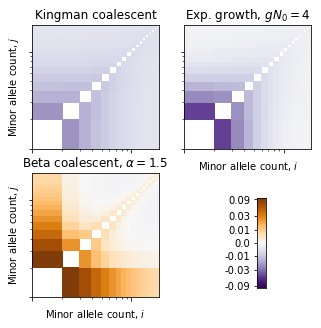

In [23]:
cmap = 'PuOr_r'
scale = 0.01
vm = 3

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(2,2,1)
wpmi_pcolor(ax, mac_theory, wpmi_kingman, scale, vm, cmap=cmap)
ax.set_title('Kingman coalescent')
ax.set_ylabel('Minor allele count, $j$')

ax = fig.add_subplot(2,2,2)
wpmi_pcolor(ax, mac_theory, wpmi_exp[-2], scale, vm, cmap=cmap)
ax.set_title('Exp. growth, $gN_0=4$')
ax.set_xlabel('Minor allele count, $i$')

ax = fig.add_subplot(2,2,3)
wpmi_pcolor(ax, mac_theory, wpmi_beta[1], scale, vm, cmap=cmap)
ax.set_title(r'Beta coalescent, $\alpha=1.5$')
ax.set_xlabel('Minor allele count, $i$')
ax.set_ylabel('Minor allele count, $j$')

# ax = fig.add_axes([0.75, 0.15, 0.025, 0.3])
ax = fig.add_axes([0.75, 0.15, 0.025, 0.25])
wpmi_colorbar(ax, scale, vm, cmap)

# fig.savefig('../manuscript/figures/Figure1.pdf')

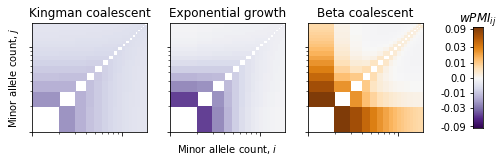

In [25]:
cmap = 'PuOr_r'
scale = 0.01
vm = 3

fig = plt.figure(figsize=(7, 2))

ax = fig.add_subplot(1,3,1)
wpmi_pcolor(ax, mac_theory, wpmi_kingman, scale, vm, cmap=cmap)
ax.set_title('Kingman coalescent')
ax.set_ylabel('Minor allele count, $j$')

ax = fig.add_subplot(1,3,2)
wpmi_pcolor(ax, mac_theory, wpmi_exp[-2], scale, vm, cmap=cmap)
ax.set_title("Exponential growth")
ax.set_xlabel('Minor allele count, $i$')

ax = fig.add_subplot(1,3,3)
wpmi_pcolor(ax, mac_theory, wpmi_beta[1], scale, vm, cmap=cmap)
ax.set_title("Beta coalescent")

ax = fig.add_axes([1, 0.15, 0.02, 0.7])
wpmi_colorbar(ax, scale, vm, cmap)
ax.set_title('$wPMI_{ij}$')

fig.savefig('../manuscript/figures/Figure1.pdf')

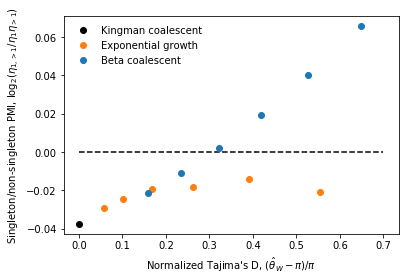

In [27]:
cutoff = 1
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(-tajimasD(n_theory, eta_kingman), lohi_pmi(eta_kingman, eta2_kingman, cutoff=cutoff), 'o', c='k',
        label='Kingman coalescent')

for i, stats in enumerate(stats_exp):
    l = ax.plot(-tajimasD(n_theory, stats[0]), lohi_pmi(*stats, cutoff=cutoff), 'o', c='C1')
    if i == 0:
        l[0].set_label('Exponential growth')
        
for i, stats in enumerate(stats_beta):
    l = ax.plot(-tajimasD(n_theory, stats[0]), lohi_pmi(*stats, cutoff=cutoff), 'o', c='C0')
    if i == 0:
        l[0].set_label("Beta coalescent")

ax.hlines(0, 0, 0.7, linestyle='dashed')
ax.set_ylabel(r"Singleton/non-singleton PMI, $\log_2(\eta_{1,>1}/\eta_{1}\eta_{>1})$")
ax.set_xlabel(r"Normalized Tajima's D, $(\hat{\theta}_W - \pi) / \pi$")
ax.legend(frameon=False)

fig.savefig('../manuscript/figures/Figure2.pdf')

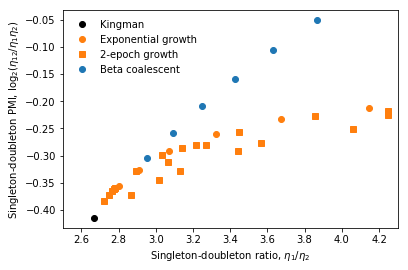

In [28]:
def plot_sd(ax, sd, sd2, *args, **kwargs):
    return ax.plot(sd[0]/sd[1], np.log2(sd2[0,1] / (sd[1]*sd[0])), *args, **kwargs)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
plot_sd(ax, sd_kingman, sd2_kingman, 'o', c='k', label='Kingman')

for i, (sd, sd2) in enumerate(sd_exp):
    l = plot_sd(ax, sd, sd2, 'o', c='C1')
    if i == 0:
        l[0].set_label("Exponential growth")
for i, (sd, sd2) in enumerate(sd_2ep):
    l = plot_sd(ax, sd, sd2, 's', c='C1')
    if i == 0:
        l[0].set_label("2-epoch growth")

for i, (sd, sd2) in enumerate(sd_beta):
    l = plot_sd(ax, sd, sd2, 'o', c='C0')
    if i == 0:
        l[0].set_label("Beta coalescent")

ax.set_xlim([2.5,4.3])
ax.set_xlabel('Singleton-doubleton ratio, $\eta_1 / \eta_2$')
ax.set_ylabel('Singleton-doubleton PMI, $\log_2(\eta_{12} / \eta_1 \eta_2)$')

ax.legend(frameon=False)

fig.savefig('../manuscript/figures/Figure3.pdf')

# Simulations

In [29]:
n_sim = 100
mac_sim = np.arange(1, (n_sim+1)//2 + 1)

# Recombination rates
r_list = np.insert(np.logspace(-1,3,13), 0, 0.0)
# Beta coalescent alpha parameter
a_list = [2.0, 1.75, 1.5, 1.25]
# Exp growth parameter
g_list = [1.0, 2.0, 4.0, 8.0]
# Piecewise-constant growth time and factor
t_list = [0.01, 0.1, 1.0]
s_list = [0.2, 0.1, 0.05, 0.01]

In [30]:
prefix = '../simulations/msprime/jsfs_n-{}_'.format(n_sim)

In [32]:
a_kingman = 2.0
a_beta = 1.5
g = 4.0

r_list_kingman = r_list[:-3]
r_list_beta = r_list[:-3]
r_list_exp = r_list[:-3]

file_list_kingman = [prefix + 'a-{}_r-{}.txt'.format(a_kingman, r) for r in r_list_kingman]
file_list_beta = [prefix + 'a-{}_r-{}.txt'.format(a_beta, r) for r in r_list_beta]
file_list_exp = [prefix + 'g-{}_r-{}.txt'.format(g, r) for r in r_list_exp]

data_kingman = h.import_msprime_corr(file_list_kingman, n_sim)
data_beta = h.import_msprime_corr(file_list_beta, n_sim)
data_exp = h.import_msprime_corr(file_list_exp, n_sim)

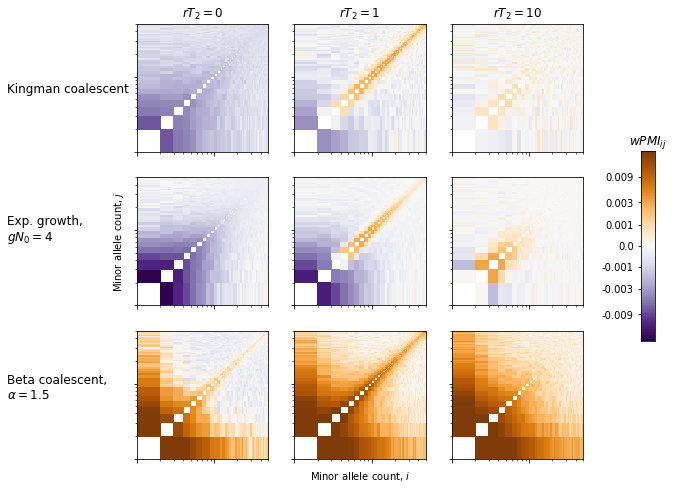

In [41]:
scale_sim = 0.001
vm_sim = 4

fig = plt.figure(figsize=(8,8))
# rT2 = 0
i_0 = 0
# rT2 = 1
i_1 = 4
i_1_exp = 5
# rT2 = 10
i_10 = 7
i_10_exp = 8



ax = plt.subplot(3, 3, 1)
wpmi_pcolor(ax, mac_sim, wpmi(data_kingman[1][i_0], data_kingman[2][i_0], n_sim), scale_sim, vm_sim, cmap=cmap)
ax.set_title('$rT_2 = 0$')
#ax.set_ylabel('Minor allele count, $j$')
ax = plt.subplot(3, 3, 2)
wpmi_pcolor(ax, mac_sim, wpmi(data_kingman[1][i_1], data_kingman[2][i_1], n_sim), scale_sim, vm_sim, cmap=cmap)
ax.set_title('$rT_2 = 1$')
ax = plt.subplot(3, 3, 3)
wpmi_pcolor(ax, mac_sim, wpmi(data_kingman[1][i_10], data_kingman[2][i_10], n_sim), scale_sim, vm_sim, cmap=cmap)
ax.set_title('$rT_2 = 10$')


ax = plt.subplot(3, 3, 4)
wpmi_pcolor(ax, mac_sim, wpmi(data_exp[1][i_0], data_exp[2][i_0], n_sim), scale_sim, vm_sim, cmap=cmap)
ax.set_ylabel('Minor allele count, $j$')
ax = plt.subplot(3, 3, 5)
wpmi_pcolor(ax, mac_sim, wpmi(data_exp[1][i_1_exp], data_exp[2][i_1_exp], n_sim), scale_sim, vm_sim, cmap=cmap)
ax = plt.subplot(3, 3, 6)
wpmi_pcolor(ax, mac_sim, wpmi(data_exp[1][i_10_exp], data_exp[2][i_10_exp], n_sim), scale_sim, vm_sim, cmap=cmap)

ax = plt.subplot(3, 3, 7)
wpmi_pcolor(ax, mac_sim, wpmi(data_beta[1][i_0], data_beta[2][i_0], n_sim), scale_sim, vm_sim, cmap=cmap)
ax = plt.subplot(3, 3, 8)
wpmi_pcolor(ax, mac_sim, wpmi(data_beta[1][i_1], data_beta[2][i_1], n_sim), scale_sim, vm_sim, cmap=cmap)
ax.set_xlabel('Minor allele count, $i$')
ax = plt.subplot(3, 3, 9)
wpmi_pcolor(ax, mac_sim, wpmi(data_beta[1][i_10], data_beta[2][i_10], n_sim), scale_sim, vm_sim, cmap=cmap)

ax = fig.add_axes([1, 0.33, 0.025, 0.33])
wpmi_colorbar(ax, scale_sim, vm_sim, cmap=cmap)
ax.set_title('$wPMI_{ij}$')

fig.text(-0.1, 0.66 + 1/10, "Kingman coalescent", fontsize=12)
fig.text(-0.1, 0.33 - 1/10, "Beta coalescent,\n"+r"$\alpha=1.5$", fontsize=12)
fig.text(-0.1, 0.5, "Exp. growth,\n$gN_0=4$", fontsize=12)

fig.savefig('../manuscript/figures/Figure4.pdf', bbox_inches="tight")

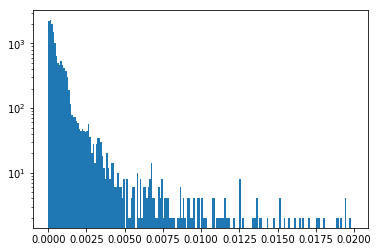

In [73]:
data = np.concatenate([np.abs(raw.ravel()) for raw in [wpmi(data_beta[1][i_0], data_beta[2][i_0], n_sim),
                                    wpmi(data_beta[1][i_1], data_beta[2][i_1], n_sim),
                                    wpmi(data_beta[1][i_10], data_beta[2][i_10], n_sim),
                                    wpmi(data_kingman[1][i_0], data_beta[2][i_0], n_sim),
                                    wpmi(data_kingman[1][i_1], data_kingman[2][i_1], n_sim),
                                    wpmi(data_kingman[1][i_10], data_kingman[2][i_10], n_sim)]])
plt.hist(data[~np.isnan(data)], bins=np.arange(0,0.02,0.0001))
plt.yscale('log')
plt.savefig('value_histogram.pdf')